## Outline:
1. Explore dataset
    - Missing or null values
    - Distributions
    - Summary statistics
3. Multicollinearity
    - Correlation matrix
    - VIF
4. Categorical variable - encoding
5. Outlier analysis
5. Split dataset into train and test set
    - Full model
        - Model summary
        - Residual analysis
6. Explore relationship
    - Different variables
    - Interaction terms?
7. Define and fit the model
8. Model summary
9. Model adequacy checking
    - Residual plots
        - Residuals vs fitted values plot - externally studenized residuals
        - Normal probability plot
    - Detection and treatment of outliers
    - Lack of fit tests
        - F test
    - Collinearity check and variable selection
    - t tests on individual regressors to edit the model
10. Define final regression equation
    - Which may be the best model?
11. Visualize the model
12. Validate the model
13. Visualize the model performance against evaluation metrics
14. Conclusion

---

Check out the dataset on Kaggle: https://www.kaggle.com/datasets/aungpyaeap/fish-market

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

#### Styles

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
df = pd.read_csv(r'C:\Users\chris\Documents\Practice_projects\Fish.csv')

# 1. Explore the dataset

In [102]:
print(df.columns)
print(df.shape)

Index(['Species', 'Weight', 'Vertical_Length', 'Diagonal_Length',
       'Cross_Length', 'Height', 'Width'],
      dtype='object')
(159, 7)


#### Column descriptions
Weight - weight of fish in grams <br>
Length1 - vertical length in cm<br>
Length2 - Diagonal length in cm<br>
Length3 - Cross length in cm<br>
Height - height in cm<br>
Width - Diagonal width in cm

In [5]:
df = df.rename({'Length1':'Vertical_Length', 'Length2':'Diagonal_Length', 'Length3':'Cross_Length'}, axis='columns')

In [6]:
# separate into category and numerical columns
df_cat = df[['Species']]
df_num = df.select_dtypes(include='number')

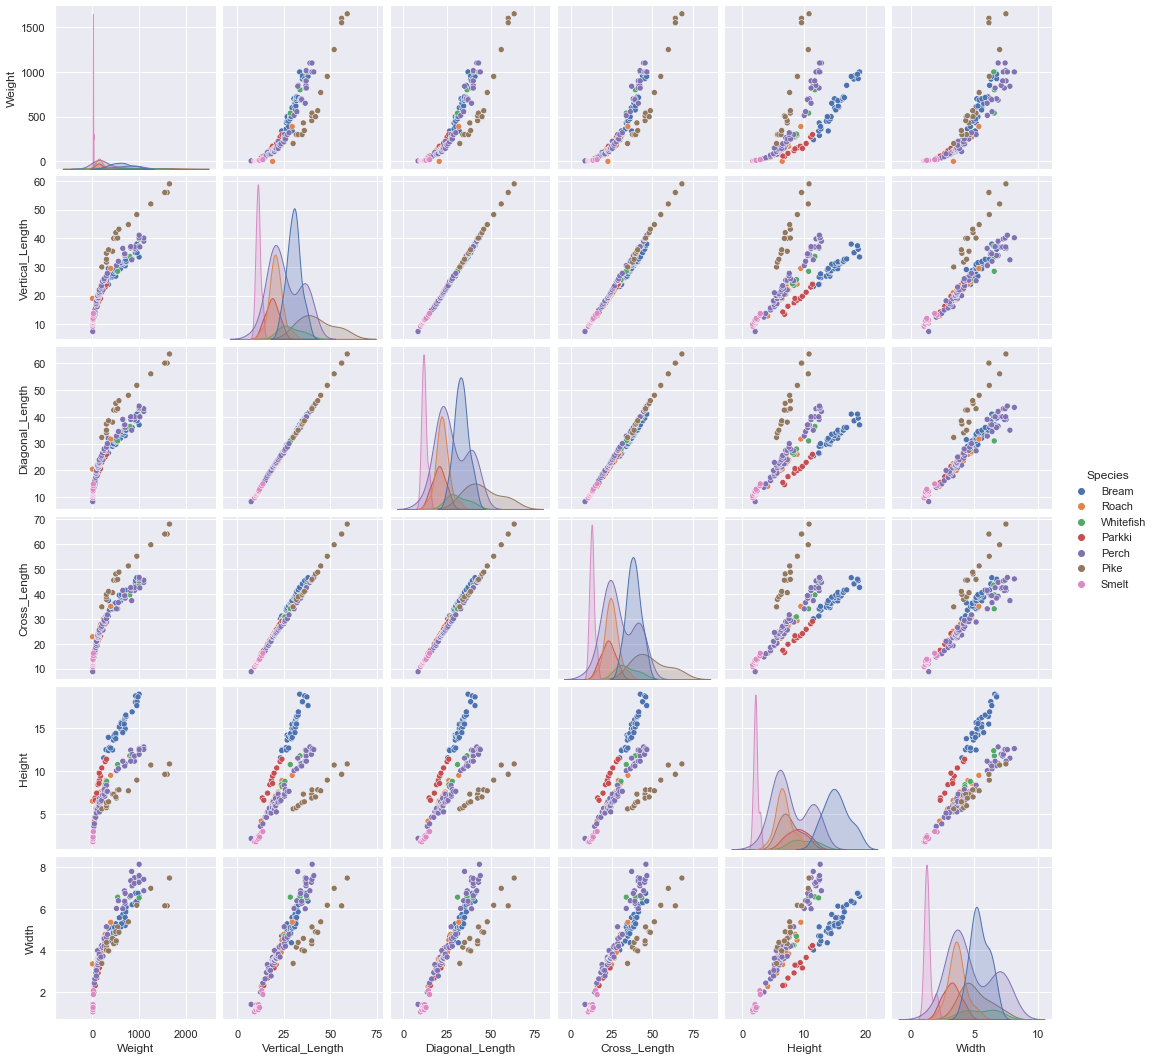

In [7]:
sns.pairplot(df, kind="scatter", hue='Species')
plt.show()

This **correlogram** (Scatter pplot matrix) allows us to see that a linear relationship may be appropriate for this dataset (although it does appear that a nonlinear model might be better), but for the sake of this example, we will continue with the linear assumption.<br>
Any regression model that is linear in the parameters is a linear regression model, regardless of the shape that it may generate (Cite: Montgomery textbook).

This means that the weight of a fish ($y$) can be computed using a linear combination of its different length measurements given the function:<br>
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5
$$

with $\beta_0$ representing the constant term.<br>
Now, we will learn the best values for our $\beta$s from the data, which is where the process for training the model begins. A trained model is a model where the $\beta$ values have been decided. A model with this parameters pre built into the formula is what constitutes a parameteric model. In other words, we fix the formula of the training function before the training.

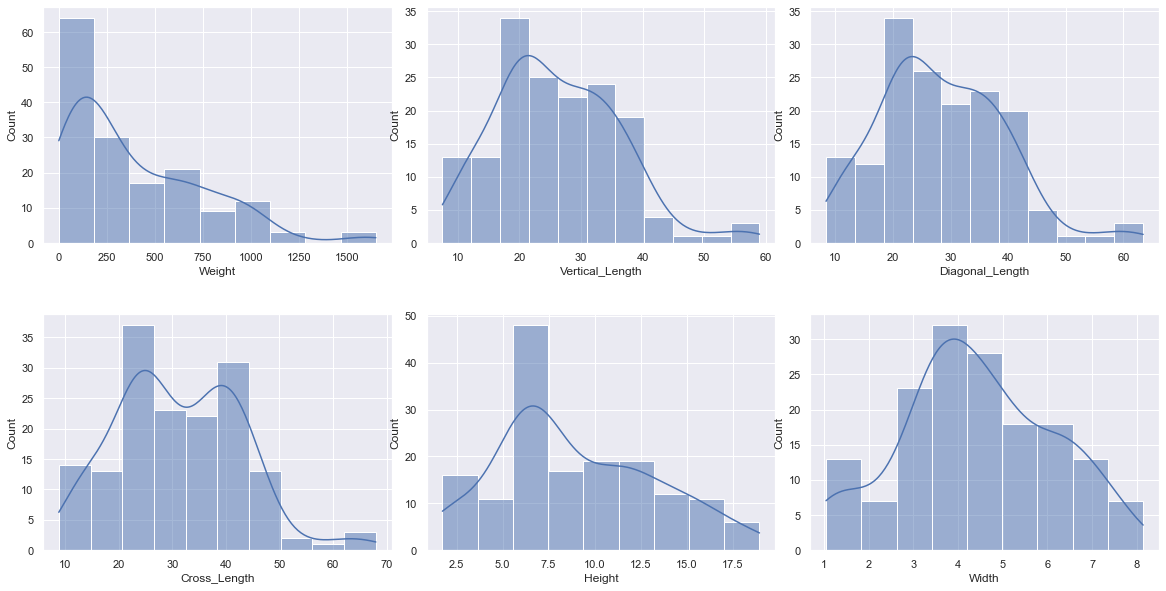

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

axes = axes.ravel()

for i, col in enumerate(df_num):
    sns.histplot(data = df[col], ax=axes[i], kde=True)

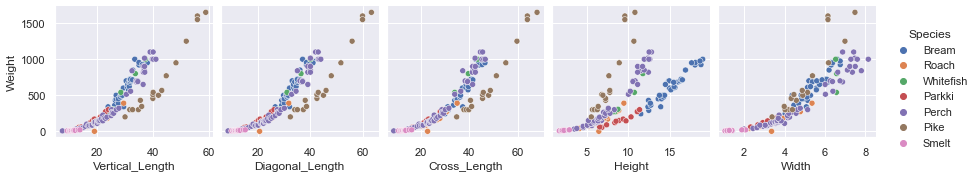

In [9]:
sns.pairplot(df, 
             x_vars=['Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Height', 'Width'],
             y_vars=['Weight'], hue='Species')

In [11]:
null_sum = df.isna().sum()
print(null_sum)

Species            0
Weight             0
Vertical_Length    0
Diagonal_Length    0
Cross_Length       0
Height             0
Width              0
dtype: int64


**Summary Statistics**

In [12]:
print(len(df))
df.describe()

159


,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


**Notes**
- Notice there are some values where the weight is equal to zero, which is impossible, so it may be an input error and could possibly remove those values
- I should maybe explore each category of species to see if any might be out of the ordinary there

In [13]:
species = df['Species'].value_counts()
species

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [14]:
# Weight cannot be 0g, so should look at those values
zeros = df[df['Weight'] == 0]
zeros

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


This fish cannot possibly weigh 0g, so we will assume for our example that maybe the value was input in error, and will delete this row

In [15]:
# high values - Pike
df[142:145]

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
142,Pike,1600.0,56.0,60.0,64.0,9.600,6.144
143,Pike,1550.0,56.0,60.0,64.0,9.600,6.144
144,Pike,1650.0,59.0,63.4,68.0,10.812,7.480


These values seem pretty high compared to the rest of the Pike weights, but I have no way to investigate if the data were entered incorrectly, or some other error occurred, so we will assume they are valid data and keep them in the model.

In [17]:
# new df with bad value removed and view summary statistics
df1 = df[df['Weight'] != 0]
df1.describe()

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,400.847468,26.293038,28.465823,31.280380,8.986790,4.424232
std,357.697796,10.011427,10.731707,11.627605,4.295191,1.689010
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,121.250000,19.150000,21.000000,23.200000,5.940600,3.398650
50%,281.500000,25.300000,27.400000,29.700000,7.789000,4.277050
75%,650.000000,32.700000,35.750000,39.675000,12.371850,5.586750
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


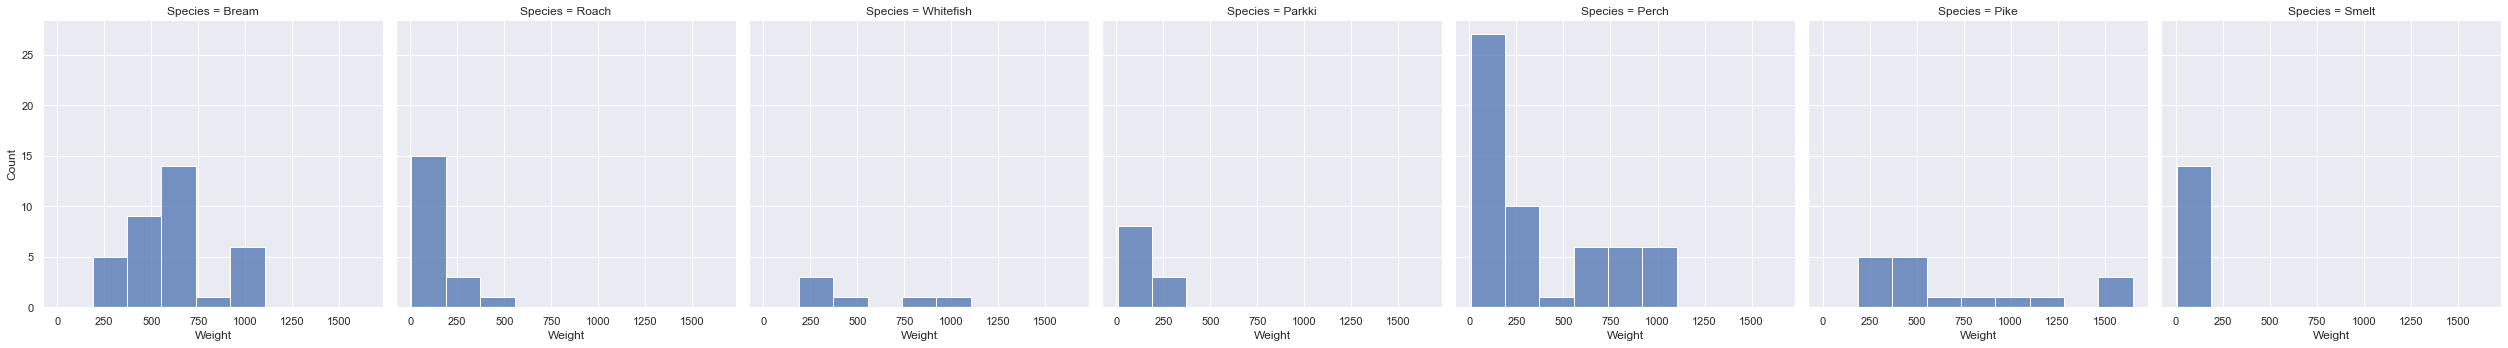

In [18]:
# trying a view of the counts by species for weight
sns.displot(
    data=df1,
    x='Weight',
    col='Species',
    kind='hist')

# 2. Multicollinearity

<AxesSubplot:>

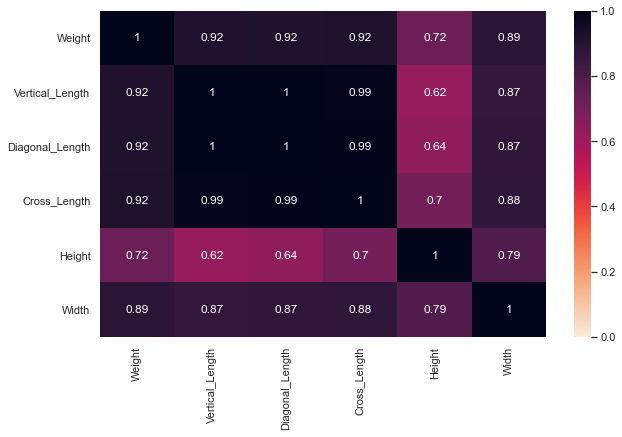

In [20]:
# make figure a bit bigger
plt.figure(figsize=(10,6))

# correlation heatmap
sns.heatmap(df1.corr(), annot=True, vmin=0, vmax=1, cmap="rocket_r")

- Note that all are pretty highly correlated, especially the length variables, height seems to have the least issues with this

In [21]:
# VIF
df1_num = df1.select_dtypes(include='number')
df1_vif = df1_num.drop(columns=['Weight'])

vif_data = pd.DataFrame()

vif_data['Column'] = df1_vif.columns

vif_data['VIF'] = [vif(df1_vif.values, i) for i in range(len(df1_vif.columns))]

vif_data.sort_values(by='VIF', ascending=True)

,Column,VIF
3,Height,76.053658
4,Width,92.653797
2,Cross_Length,3382.291295
0,Vertical_Length,12749.616323
1,Diagonal_Length,16580.478064


- All of these have a very high VIF if using the rule of thumb;
    - 1 = not correlated
    - Between 1 and 5 = moderately correlated
    - Greater than 5 = highly correlated
    
- Although how large is subjective, and these VIF values may not be a cause for concern because of nonlinearity

# 3. Categorical variables

In [22]:
# categorical encoding
df2 = pd.get_dummies(df1)
df2

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,0,1,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,0,1,0


# 4. Outlier analysis

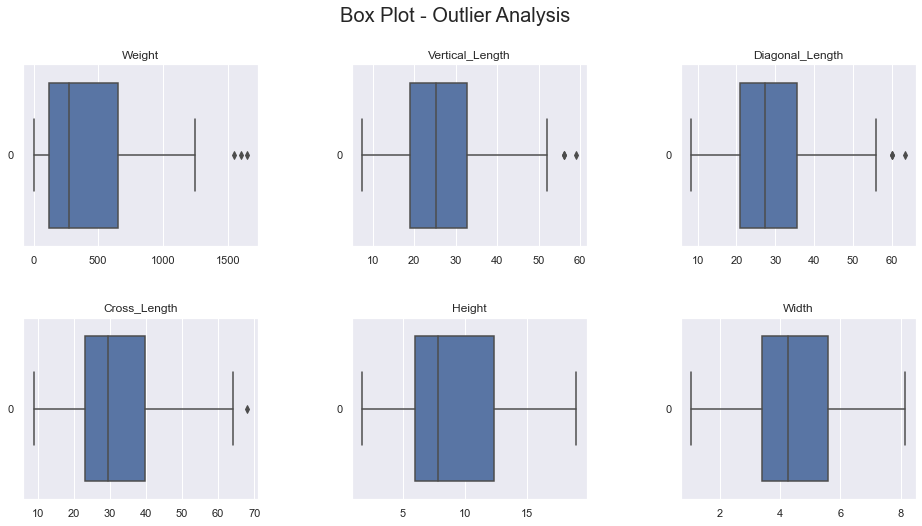

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle('Box Plot - Outlier Analysis', fontsize=20)

for i, col in enumerate(df_num):
    box=sns.boxplot(data=df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

Note: It seems there are three values that might be a cause for concern, so we will fit the model with and without them, and compare results

# 5. Split into train and test sets
- Then we will fit the full model to use for comparison when we explore further
    - SKLearn
    - Statsmodels

In [90]:
# we will split using the data frame with the dummy variables
# Note: this data frame is the full data frame - no variables or outliers yet removed
X = df2.iloc[:, 1:13]
y = df2[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [91]:
print('X_train: ', np.shape(X_train))
print('y_train: ', np.shape(y_train))

X_train:  (126, 12)
y_train:  (126, 1)


In [92]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [94]:
# Parameters of the model
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)
print('Model score: ', model.score(X, y))

Model intercept:  [-770.14347974]
Model coefficients:  [[ -63.22928996   65.94960078   32.63084902  -13.48771047   14.76723657
   -23.75789954  109.67672503   14.62998401 -386.38116849  -14.93776981
   289.50304796   11.26708083]]
Model score:  0.9337286488017511


In [95]:
# predicting weights from the training set
y_hat = model.predict(X_test)

In [96]:
# Analyzing success of model from training set and predictions
# r2_score(y_train, y_hat)    # 0.92899
r2_score(y_test, y_hat)

0.9497220657678437

In [97]:
cross_val_score_train = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)

[0.91460715 0.92930082 0.94413659 0.95228034 0.88054843 0.91759335
 0.86789262 0.91666792 0.87158136 0.60033489]


In [98]:
cross_val_score_train.mean()

0.8794943472072945

In [99]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 6749.345
RMSE: 82.154
MAE: 7.952


In [34]:
# using the original model (full), I will look at the statsmodels package results

In [100]:
Xsm = df2.iloc[:, 1:13]
ysm = df2[['Weight']]

X_sm = sm.add_constant(Xsm)
sm_model = sm.OLS(ysm, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     193.6
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           3.46e-81
Time:                        15:52:50   Log-Likelihood:                -935.71
No. Observations:                 158   AIC:                             1895.
Df Residuals:                     146   BIC:                             1932.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -708.1028     47.425    -14.931      0.000    -801.830    -614.375
Vertical_Length     -79.8443     36.332     -2.198      0.030    -151.649      -8.039
Diagonal_Length      81.7091     45.840      1.783      0.077      -8.886     172.304
Cross_Length         30.2726     29.484      1.027      0.306     -27.997      88.543
Height                5.8069     13.093      0.444      0.658     -20.070      31.683
Width                -0.7819     23.948     -0.033      0.974     -48.111      46.547
Species_Bream      -204.6082     90.149     -2.270      0.025    -382.774     -26.442
Species_Parkki      -43.6870     41.700     -1.048      0.297    -126.100      38.726
Species_Perch       -71.0540     37.227     -1.909      0.058    -144.628       2.520
Species_Pike       -413.6345     70.011     -5.908      0.000    -552.001    -275.268
Species_Roach       -99.6840     24.758     -4.026      0.000    -148.615     -50.753
Species_Smelt       237.6043     38.282      6.207      0.000     161.945     313.263
Species_Whitefish  -113.0395     38.640     -2.925      0.004    -189.405     -36.673
==============================================================================
Omnibus:                       43.200   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.476
Skew:                           1.180   Prob(JB):                     1.12e-21
Kurtosis:                       6.014   Cond. No.                     1.08e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.98e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> **Residual Analysis**

Text(0, 0.5, 'Residual')

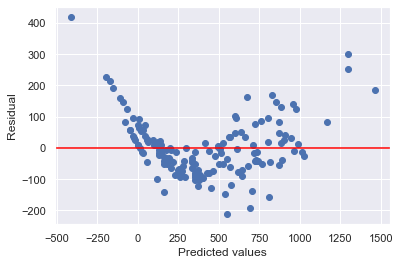

In [103]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')

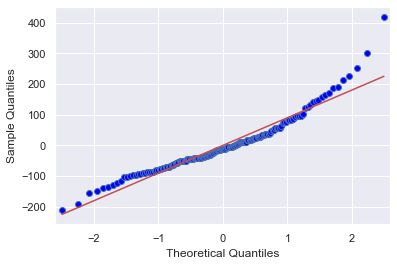

In [104]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Clearly, it mostly follows the line except for three points at the top, which one may or may not remove, depending on preference

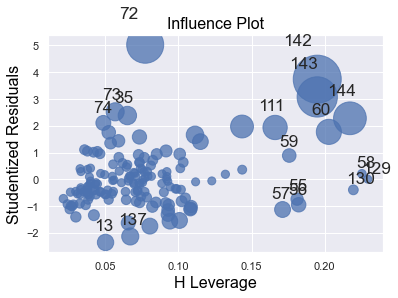

In [105]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')

In [106]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(df2)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(df2.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.02531645569620253
Int64Index([29, 35, 60, 61, 72, 73, 111, 142, 143, 144], dtype='int64') 
 [0.04908493 0.02939549 0.06050667 0.02622718 0.13940131 0.02830891
 0.05630748 0.2391189  0.16651345 0.10773821]


Clearly, there are some points that seem to have a high amount of leverage or influence

# 6. Explore relationships
- Test with different variables
- Test with possible interaction terms


---

| Model  | $R^2$ | Adj. $R^2$ | F-Statistic | RMSE | Notes |
| ------ | ----- | ---------- | ----------- | ---- | :--- |
| Full | 0.936 | 0.931 | 193.6 | 90.652| Lots of issues with the variables |
| Vertical Length | 0.93 | 0.927 | 220.9 | 90.652 | Width and height p values are still high |
| Diagonal Length | 0.933 | 0.929 | 230.0 | 87.159 | Same |
| Cross Length | 0.934 | 0.930 | 231.6 | 87.144 | Same |
| Int - Vertical | 0.973 | 0.971 | 526.4 | 63.345 | Good p values if a = 0.05, residuals look better than full |
| Int - Diagonal | 0.973 | 0.971 | 529.1 | 63.318 | Same |
| Int - Cross | 0.973 | 0.971 | 528.7 | 62.310 | High p-value for width |

In [59]:
# do again, but with only one length column
X = df2.drop(columns=['Weight', 'Vertical_Length', 'Diagonal_Length'])
y = df2[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [61]:
y_hat = lr.predict(X_test)

In [62]:
r2_score(y_test, y_hat)
# Cross length - 0.9434291295580692
# Vert - 0.9387835896394756
# diag - 0.9387835896394756

0.9434291295580692

In [63]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 7594.113
RMSE: 87.144
MAE: 8.016


In [64]:
# testing with different parameters - interaction terms
# vert - 0.973, 0.971, f 526.4
# cross - f 528.7, issues with p value of width
# diag - f 529.1, issues with width
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.63e-82
Time:                        15:34:11   Log-Likelihood:                -938.31
No. Observations:                 158   AIC:                             1897.
Df Residuals:                     148   BIC:                             1927.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -684.6471     33.366    -20.519      0.000    -750.582    -618.712
Cross_Length         36.1375      3.621      9.980      0.000      28.982      43.293
Height                9.0784     13.107      0.693      0.490     -16.822      34.979
Width                -4.6968     24.060     -0.195      0.845     -52.242      42.849
Species_Bream      -195.8982     64.292     -3.047      0.003    -322.947     -68.850
Species_Parkki      -50.3780     41.783     -1.206      0.230    -132.946      32.190
Species_Perch       -50.8339     22.853     -2.224      0.028     -95.995      -5.673
Species_Pike       -403.3187     70.404     -5.729      0.000    -542.446    -264.191
Species_Roach      -105.4074     22.473     -4.690      0.000    -149.818     -60.997
Species_Smelt       210.9845     31.995      6.594      0.000     147.758     274.211
Species_Whitefish   -89.7954     37.319     -2.406      0.017    -163.542     -16.049
==============================================================================
Omnibus:                       40.058   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.675
Skew:                           1.112   Prob(JB):                     2.49e-19
Kurtosis:                       5.840   Cond. No.                     4.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Interaction terms

In [111]:
df2['Volume'] = df2['Height']*df2['Width']*df2['Vertical_Length']

In [112]:
X = df2.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df2[['Weight']]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9701085869761379
Adj r2:  0.9536683098130138
MSE: 4012.644
RMSE: 63.345
MAE: 6.850


In [114]:
# testing with different parameters - interaction terms
# vert - 0.973, 0.971, f 526.4
# cross - f 528.7, issues with p value of width
# diag - f 529.1, issues with width
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     526.4
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          9.95e-110
Time:                        16:02:31   Log-Likelihood:                -867.83
No. Observations:                 158   AIC:                             1758.
Df Residuals:                     147   BIC:                             1791.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -84.1519     41.035     -2.051      0.042    -165.246      -3.057
Vertical_Length      26.5681      2.631     10.100      0.000      21.370      31.767
Height              -45.4817      9.222     -4.932      0.000     -63.706     -27.257
Width               -35.6302     15.586     -2.286      0.024     -66.432      -4.828
Species_Bream       118.1846     45.897      2.575      0.011      27.482     208.887
Species_Parkki      113.8075     29.102      3.911      0.000      56.295     171.320
Species_Perch       -28.3067     14.827     -1.909      0.058     -57.608       0.994
Species_Pike       -273.1047     45.338     -6.024      0.000    -362.703    -183.506
Species_Roach       -12.8172     15.533     -0.825      0.411     -43.514      17.880
Species_Smelt       -64.5251     26.413     -2.443      0.016    -116.724     -12.326
Species_Whitefish    62.6098     25.891      2.418      0.017      11.443     113.777
Volume                0.2542      0.017     15.094      0.000       0.221       0.288
==============================================================================
Omnibus:                       36.382   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.827
Skew:                           0.628   Prob(JB):                     2.46e-44
Kurtosis:                       8.378   Cond. No.                     2.59e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.54e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> Lets use the interaction term with vertical length for residual analysis

Text(0, 0.5, 'Residual')

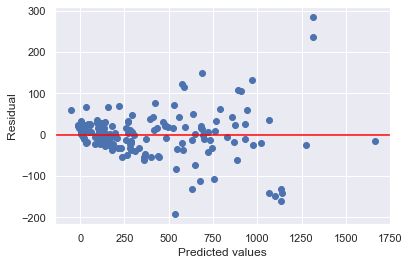

In [115]:
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')

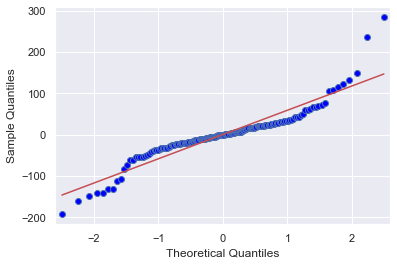

In [116]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

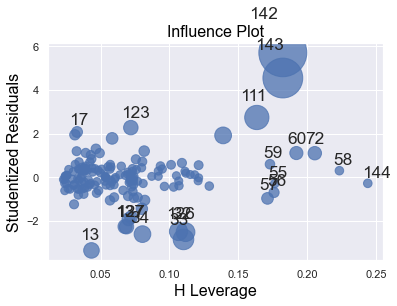

In [117]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')

In [118]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(df2)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(df2.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.02531645569620253
Int64Index([13, 29, 32, 33, 34, 72, 111, 123, 126, 127, 137, 142, 143], dtype='int64') 
 [0.03990263 0.04851492 0.06433777 0.08024599 0.04785386 0.02601876
 0.11687917 0.03246339 0.05962958 0.03109708 0.03026232 0.4982924
 0.33892494]


In [120]:
df2.columns

Index(['Weight', 'Vertical_Length', 'Diagonal_Length', 'Cross_Length',
       'Height', 'Width', 'Species_Bream', 'Species_Parkki', 'Species_Perch',
       'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish',
       'Volume'],
      dtype='object')

In [ ]:
# 2 - 42.56, .980, 742.6, residuals look good
# 3 - 39.713, .980 same
# 4 - 111 - worse
# 4 - 72 - worse
# 5 - worse

In [214]:
# outlier removal and variable selection
df3 = df2.drop([142, 143, 144])

In [177]:
len(df3)

155

In [178]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9858885592047286
Adj r2:  0.9777187776916768
MSE: 1577.113
RMSE: 39.713
MAE: 5.347


In [179]:
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     717.4
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.73e-117
Time:                        16:26:29   Log-Likelihood:                -808.66
No. Observations:                 155   AIC:                             1639.
Df Residuals:                     144   BIC:                             1673.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -94.3044     32.036     -2.944      0.004    -157.625     -30.984
Vertical_Length      13.2497      2.399      5.524      0.000       8.509      17.991
Height              -19.9179      7.835     -2.542      0.012     -35.405      -4.431
Width                 4.3251     12.450      0.347      0.729     -20.284      28.934
Species_Bream         7.4144     37.881      0.196      0.845     -67.461      82.289
Species_Parkki       33.7932     24.444      1.382      0.169     -14.522      82.108
Species_Perch       -24.9950     11.308     -2.210      0.029     -47.345      -2.645
Species_Pike       -104.1791     38.610     -2.698      0.008    -180.495     -27.863
Species_Roach       -27.5260     11.928     -2.308      0.022     -51.103      -3.949
Species_Smelt       -13.3744     21.376     -0.626      0.533     -55.626      28.878
Species_Whitefish    34.5625     19.948      1.733      0.085      -4.867      73.992
Volume                0.2234      0.014     16.086      0.000       0.196       0.251
==============================================================================
Omnibus:                       18.950   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.740
Skew:                          -0.145   Prob(JB):                     7.98e-18
Kurtosis:                       6.480   Cond. No.                     1.12e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Residual')

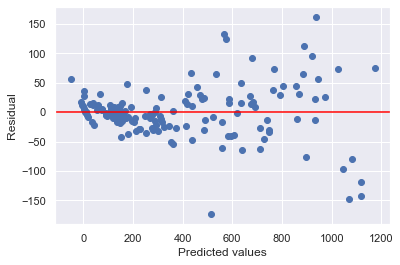

In [180]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')

 From the residual plot, it looks as though it is random for high values, but not random for lower values

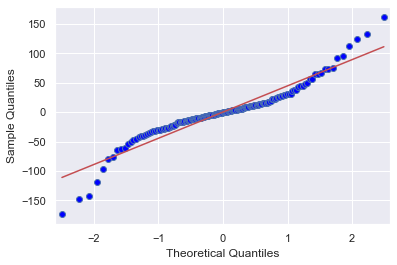

In [181]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Clearly, it mostly follows the line except for three points at the top, which one may or may not remove, depending on preference

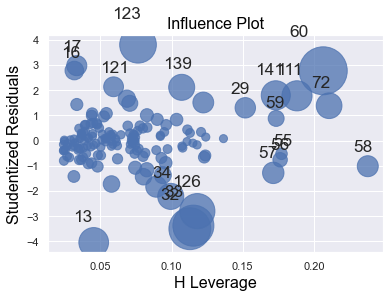

In [170]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')

In [171]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(df3)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(df3.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.025806451612903226
Int64Index([13, 32, 33, 34, 57, 58, 60, 72, 111, 123, 126, 127, 139, 140, 141], dtype='int64') 
 [0.05838871 0.12030645 0.11553936 0.04395215 0.02814964 0.02683146
 0.15949939 0.04246364 0.06023508 0.09141012 0.08353053 0.02690198
 0.04371832 0.02636892 0.05572861]


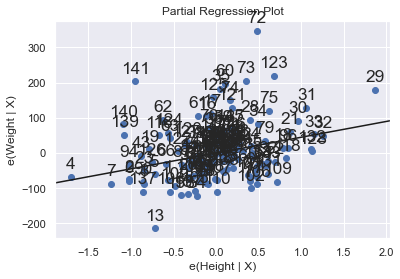

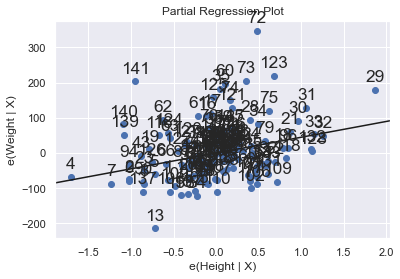

In [173]:
sm.graphics.plot_partregress(
    endog='Weight',
    exog_i = 'Height',
    exog_others=['Width', 'Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Species_Bream', 'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Whitefish', 'Species_Smelt'],
    data=df3,
    obs_labels=True)

In [219]:
# Random forest regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predictions
y_hat = rf.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-rf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9679883430377405
Adj r2:  0.9609457785060435
MSE: 3617.921
RMSE: 60.149
MAE: 6.092


<ipython-input-219-334b40023b29>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


In [186]:
df4 = df3.drop(columns=['Diagonal_Length', 'Cross_Length'])
print(len(df4))
print(df4.columns)
df4.describe()

155
Index(['Weight', 'Vertical_Length', 'Height', 'Width', 'Species_Bream',
       'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach',
       'Species_Smelt', 'Species_Whitefish', 'Volume'],
      dtype='object')


,Weight,Vertical_Length,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish,Volume
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,377.638065,25.698710,8.967102,4.382326,0.225806,0.070968,0.361290,0.090323,0.122581,0.090323,0.038710,1382.132933
std,319.144511,9.133355,4.333722,1.675564,0.419468,0.257603,0.481932,0.287573,0.329018,0.287573,0.193527,1233.809560
min,5.900000,7.500000,1.728400,1.047600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.940572
25%,120.000000,19.050000,5.926950,3.385650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,413.713963
50%,272.000000,25.000000,7.680000,4.247600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,851.553815
75%,615.000000,32.250000,12.379300,5.472750,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2351.009108
max,1250.000000,52.000000,18.957000,8.142000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4702.624927


In [211]:
# now do some weight predictions with favored model
pred = lr.predict(np.array([[24.0, 12.0, 5.0, 1, 0, 0, 0, 0, 0, 0, 24*12*5]]))
print(pred)

[[334.98801576]]


C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [215]:
# check with larger test set

X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.97969776862565
Adj r2:  0.975231277723293
MSE: 2294.535
RMSE: 47.901
MAE: 5.629


In [216]:
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     717.4
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.73e-117
Time:                        17:12:43   Log-Likelihood:                -808.66
No. Observations:                 155   AIC:                             1639.
Df Residuals:                     144   BIC:                             1673.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -94.3044     32.036     -2.944      0.004    -157.625     -30.984
Vertical_Length      13.2497      2.399      5.524      0.000       8.509      17.991
Height              -19.9179      7.835     -2.542      0.012     -35.405      -4.431
Width                 4.3251     12.450      0.347      0.729     -20.284      28.934
Species_Bream         7.4144     37.881      0.196      0.845     -67.461      82.289
Species_Parkki       33.7932     24.444      1.382      0.169     -14.522      82.108
Species_Perch       -24.9950     11.308     -2.210      0.029     -47.345      -2.645
Species_Pike       -104.1791     38.610     -2.698      0.008    -180.495     -27.863
Species_Roach       -27.5260     11.928     -2.308      0.022     -51.103      -3.949
Species_Smelt       -13.3744     21.376     -0.626      0.533     -55.626      28.878
Species_Whitefish    34.5625     19.948      1.733      0.085      -4.867      73.992
Volume                0.2234      0.014     16.086      0.000       0.196       0.251
==============================================================================
Omnibus:                       18.950   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.740
Skew:                          -0.145   Prob(JB):                     7.98e-18
Kurtosis:                       6.480   Cond. No.                     1.12e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Residual')

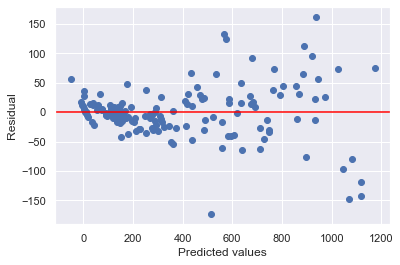

In [217]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')

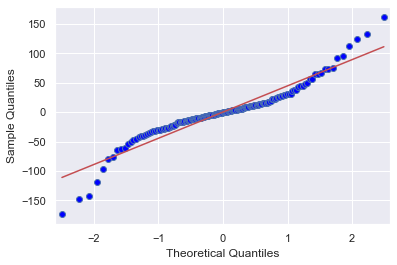

In [218]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()